# IMDB ratings review classification

In [1]:
# uploading required files 
from google.colab import files 
a = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
data = pd.read_csv("/content/IMDB Dataset.csv")
data.sample(5)

,review,sentiment
3778,"Directed by E. Elias Merhige ""Begotten"" is an ...",negative
7078,"At it's core, this is a fairly typical revenge...",negative
38088,I'm normally not a Drama/Feel good movie kind ...,positive
13894,You can do a lot with a little cash. Blair Wit...,positive
36561,I was a schoolboy when I watched this film for...,positive


In [5]:
# replacing the target column values with binary values 
data['sentiment'].replace('positive', 1, inplace=True)
data['sentiment'].replace('negative', 0, inplace=True)

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Visualization

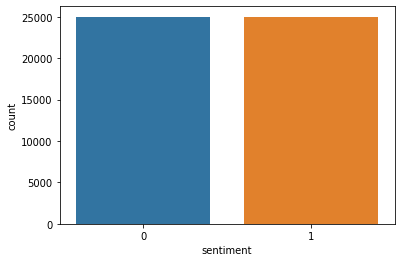

In [7]:
sns.countplot(x='sentiment', data=data)

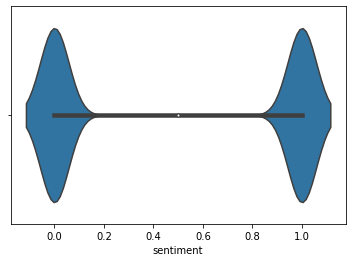

In [8]:
sns.violinplot(x='sentiment', data=data)

## Preprocessing

In [9]:
columns = []
for i in data.columns:
  columns.append(i)

columns

['review', 'sentiment']

In [10]:
# checking for null values 
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
data.shape

(50000, 2)

In [12]:
data.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [14]:
big = data['review'][0]

for i in data['review']:
  if len(i) > len(big):
    big = i
print(big)

Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, but

In [15]:
small = data['review'][0]
for i in data['review']:
  if len(i) < len(small):
    small = i
print(small)

Read the book, forget the movie!


In [16]:
for i in range(len(data['review'])):
  if data['review'][i] == "Read the book, forget the movie!":
    print("The smallest review is at index ",i)

The smallest review is at index  27521


## Text processing

In [19]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [18]:
x = data['review']
y = data['sentiment']

In [22]:
tokenizer = Tokenizer(10000, lower=True)
tokenizer.fit_on_texts(x)
sequence = tokenizer.texts_to_sequences(x)
encoded_seq = pad_sequences(sequence, maxlen=200, padding='pre')

In [23]:
final_input = encoded_seq
final_output = np.array(y)

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final_input,final_output, test_size=0.33, random_state=42)

print(x_train.shape,y_train.shape)

(33500, 200) (33500,)


## Model building

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dropout, Dense, Embedding

In [27]:
model = Sequential()
model.add(
    Embedding(
        input_dim=10000,
        output_dim=120,
        input_length=200),)
model.add(
    Bidirectional(LSTM(64, return_sequences=True))
)
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 120)          1200000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          94720     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,336,001
Trainable params: 1,336,001
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

prediction = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=2,batch_size=32)


Epoch 1/2
1047/1047 [==============================] - 496s 449ms/step - loss: 0.7088 - accuracy: 0.6758 - val_loss: 0.3961 - val_accuracy: 0.8484
Epoch 2/2
1047/1047 [==============================] - 469s 448ms/step - loss: 0.3567 - accuracy: 0.8590 - val_loss: 0.4789 - val_accuracy: 0.7841


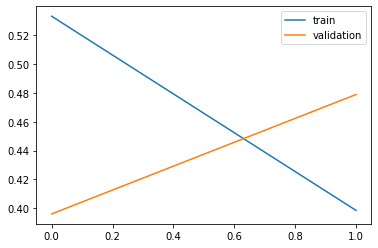

In [29]:
plt.plot(prediction.history['loss'],label='train')
plt.plot(prediction.history['val_loss'],label='validation')
plt.legend(loc='best')

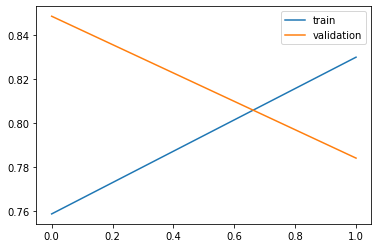

In [30]:
plt.plot(prediction.history['accuracy'],label='train')
plt.plot(prediction.history['val_accuracy'],label='validation')
plt.legend(loc='best')

In [31]:
model.save("imdb review.h5")

## Custom review predictor bot

In [32]:
def imdb_bot(review):
  sentence = []
  sentence.append(review)
  sequence = tokenizer.texts_to_sequences(sentence)
  input = pad_sequences(sequence, maxlen=200, padding='pre')
  output = model.predict_classes(input)
  if output.all() == 1:
    print("The reviews are good you should watch this")
  else:
    print("The reviews are not quite good you should try another one")

In [33]:
imdb_bot("Mission Impossible")

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The reviews are not quite good you should try another one


In [36]:
imdb_bot("3 idiots")

The reviews are not quite good you should try another one


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
